In [1]:
code accompanying P Selvakumar and R Siddharthan, "Position-specific evolution in transcription factor binding
  sites, and a fast likelihood calculation for the F81 model"
  
tested with Julia 1.9.1

LoadError: syntax: extra token "accompanying" after end of expression

In [2]:
using NLopt
using Logomaker

#### NodeData contains the data for the node: 
`label` comes from the Newick string
`labelnum` is created by the function `set_labelnums!` and is a unique positive number corresponding to each leaf (internal nodes have `labelnum` 0
`q` is proximity of node to its parent ($q = \exp (-\mu t)$ where $\mu$ is mutation rate and $t$ is evolutionary time)

In [3]:
mutable struct NodeData
    label::String
    labelnum::Int64 # for efficiency, encode labels by unique numbers
    lik_a::Vector{Float64} # partial likelihoods to be stored for Felsenstein algorithm
    q::Float64 # evolutionary time in units of inverse mutation rate such that exp(-t) = q
end

In [4]:
mutable struct Node
    data::NodeData
    children::Vector{Union{Nothing,Node}}
    function Node(data)
        new(data,[])
    end
end

code to convert Newick strings to trees and vice versa

In [5]:
function split_string_by_bracket(s)
    splitlist = []
    substr = ""
    nleft = 0
    nright = 0
    for c in s
        if c == '('
            nleft += 1
        elseif c == ')'
            nright += 1
        end
        if c==',' && nleft==nright
            push!(splitlist,substr)
            substr = ""
        else
            substr *= c
        end
    end
    push!(splitlist, substr)
    return splitlist
end
        
function newick_to_tree(s::String)
    if s[end] == ';'    # full tree
        if s[end-1]==')'  # no root height
            height = 0.0
        else
            height = parse(Float64,split(s,":")[end][1:end-1])
              # the thing after ":" and before ;
        end
    else
        height = parse(Float64,split(s,":")[end]) # no ; for internal nodes
    end
    tree = Node(NodeData("",0,[-1.0,-1.0,-1.0,-1.0],height))
    if s[1]=='(' # find closing brace
        last = length(s)
        try
            while s[last]!= ')'
                last -= 1
            end
        catch
            println(s)
            throw(ArgumentError)
        end
        children = split_string_by_bracket(s[2:last-1])
        tree.children = [newick_to_tree(c) for c in children]
    else # leaf
        label = split(s,":")[1]
        tree.data = NodeData(label,0,[-1.0,-1.0,-1.0,-1.0],tree.data.q)
    end
    return tree
end
            

newick_to_tree (generic function with 1 method)

In [6]:
function tree_to_newick(t::Node, depth::Int64=0)
    if depth==0
        endtoken = ";"
    else
        endtoken = ""
    end
    if t.children == []
        return t.data.label*":"*string(t.data.q)*endtoken
    else
        return "("*join([tree_to_newick(c,depth+1) for c in t.children],",")*"):"*string(t.data.q)*endtoken
    end
end

tree_to_newick (generic function with 2 methods)

Get all leaves below a node, by depth first search

In [7]:
function get_leaves(t::Node)
    if t.children==[]
        return [t.data]
    else
        return reduce(vcat,[get_leaves(c) for c in t.children])
    end
end

get_leaves (generic function with 1 method)

In [8]:
function get_internal_nodes(t::Node)
    if t.children==[]
        return NodeData[]
    else
        return reduce(vcat,[t.data; [get_internal_nodes(c) for c in t.children]])
    end
end

get_internal_nodes (generic function with 1 method)

set labelnums to a tree, remember to do this before calling any other routines
(to ensure it, below is a wrapper function that also calls newick_to_tree)

unique numbers are attached, first to leaves, then to internal nodes

In [9]:
function set_labelnums!(t::Node)
    leaves = get_leaves(t)
    inodes = get_internal_nodes(t)
    nl = length(leaves)
    nin = length(inodes)
    for n in 1:nl+nin
        if n <= nl
            leaves[n].labelnum = n
        else
            inodes[n-nl].labelnum = n
        end
    end
    return [l.label for l in leaves]
end

# returns a tree, as well as a list of leaves in the same order as labelnum
function treeFromNewick(s::String)
    t = newick_to_tree(s)
    leaves = set_labelnums!(t)
    return t,leaves
end

treeFromNewick (generic function with 1 method)

### maybe not needed; remove?

In [10]:
function set_qlist_all!(tree::Node,q::Float64)
    tree.data.q = q
    for c in tree.children
        c.data.q = q
        set_qlist_all!(c,q)
    end
end

set_qlist_all! (generic function with 1 method)

##### HKY85 model: 
Rate matrix is
$$ R = \begin{bmatrix}
* & \pi_A & \kappa \pi_A & \pi_A \\
\pi_C & * & \pi_C & \pi_C \\
\kappa \pi_G & \pi_G & * & \kappa \pi_G \\
\pi_T & \kappa \pi_T & \pi_T & * \end{bmatrix}$$

where *columns* sum to zero (in some other presentations, *rows* sum to zero). $\kappa$ is the transition-transversion ratio.  In terms of this, the transition probabilities are 

identity, $\beta=\alpha$ for $\alpha = A,G$:

$P_{\beta\alpha} = \pi_\alpha + \pi_\alpha \frac{\pi_Y}{\pi_R} e_2 + \left(1-\frac{\pi_\alpha}{\pi_R}\right)e_3$


identity, $\beta=\alpha$ for $\alpha = C,T$:

$P_{\beta\alpha} = \pi_\alpha + \pi_\alpha \frac{\pi_R}{\pi_Y} e_2 + \left(1-\frac{\pi_\alpha}{\pi_Y}\right)e_4$

Transition, purine:

$P_{\beta\alpha} = \pi_\beta\left(1+\frac{\pi_Y}{\pi_R} e_2 - \frac{1}{\pi_R}e_3 \right)$

Transition, pyrimidine: 

$P_{\beta\alpha} = \pi_\beta\left(1+\frac{\pi_R}{\pi_Y} e_2 - \frac{1}{\pi_Y}e_4 \right)$

Transversion:

$P_{\beta\alpha} = \pi_\beta(1-e_2)$

where $e_2 = e^{-t} \equiv q$, $e_3 = q^{\kappa \pi_R + \pi_Y}$ and $e_4 = q^{\kappa \pi_Y + \pi_R}$.

### HKY likelihood calculation

Note convention

A=1, C=2, G=3, T=4 because of Julia's 1-indexing

In [11]:
function hkyS(β::Int64,α::Int64,q::Float64, κ::Float64, statprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    # α, β are 1,2,3,4 == A, C, G, T
    # q is proximity
    # statprob = stationary probability distribution (π vector)
    # this is prob of ancestor α mutating to descendant β
    πα = statprob[α]
    πβ = statprob[β]
    πR = statprob[1]+statprob[3]
    πY = statprob[2]+statprob[4]
    e2 = q
    e3 = q^(κ*πR+πY)
    e4 = q^(κ*πY+πR)
    if α==β==1 || α==β==3 # identity, purine
        return πα + πα*(πY/πR)*e2 + (1-πα/πR)*e3
    elseif α==β==2 || α==β==4 # identity, pyrimidine
        return πα + πα*(πR/πY)*e2 + (1-πα/πY)*e4
    elseif (α==1 && β==3) || (α==3 && β==1) # transition, purine
        return πβ*(1+(πY/πR)*e2-e3/πR)
    elseif (α==2 && β==4) || (α==4 && β==2) # transition, pyrimidine
        return πβ*(1+(πR/πY)*e2 - e4/πY)
    else # transversion
        return πβ*(1-e2)
    end
end

hkyS (generic function with 2 methods)

### TFBS evolution:

1. take collection of neutral sites ($\vec{\pi}$ = (0.25,0.25,0.25,0.25) or background freqs), learn the $q$'s and $\kappa$
   * requires a tree with fixed topology. Then fit the $q$'s and $\kappa$ as in the methods
2. take HKY $T$ using these $q$'s and $\kappa$ and a $\vec{\pi}$ to be learned
3. maximum-likelihood estimation of $\vec{\pi}$ per position in TFBS 

### Learning the maximum likelihood $q$ values for a collection of neutral sites

1. convert $q$'s to a vector for use in `optimize` (from `NLopt` package)
2. if tree has $N$ nodes, there are $N-2$ $q$'s for binary tree, because root node has no height, and 
we can assume one of the children (right child) has no height ($q=1$).  
2a. if root has more than 2 children, we need to assign $q$ for each child.
3. function to be minimized = Felsenstein likelihood for leaves as a function of $q$'s and fixed tree topology.

In [12]:
is_leaf(t::Node) = t.children==[]

is_leaf (generic function with 1 method)

##### Felsenstein algorithm for likelihood

Assumes binary tree. Uses dictionary for caching results



In [13]:
function likelihood_one(node::Node,sites::Array{Int64,2},sitepos::Int64,a::Int64, 
        ll_dict::Dict{Tuple{Int64, Int64, Vector{Int64}}, Float64}, κ::Float64, statprob::Vector{Float64})
    # likelihood of leaves below node given node value is a: Felsenstein's algorithm
    # assume binary tree
    if node.children == [] # leaf
        if sites[node.data.labelnum,sitepos]==a
            return 1.0
        else
            return 0.0
        end
    elseif length(node.children)==1 # single leaf case, should occur only with root node
        return statprob[node.children[1].data.labelnum]
    else
        key1 = (node.data.labelnum, a, [sites[l.labelnum,sitepos] for l in get_leaves(node)])
        #println(key1, node.data, ll_dict)
        if haskey(ll_dict,key1)
            return ll_dict[key1]
        else
            lik = 0.0
            left = node.children[1]
            right = node.children[2]
            for b in 1:4
                for c in 1:4
                    lik += hkyS(b,a,left.data.q,κ)*likelihood_one(left,sites,sitepos,b,ll_dict,κ,statprob) *
                    hkyS(c,a,right.data.q,κ)*likelihood_one(right,sites,sitepos,c,ll_dict,κ,statprob)
                end
            end
            ll_dict[key1] = lik
            return lik
        end
    end
end

function likelihood_all(root::Node, sites::Array{Int64,2}, sitelen::Int64, κ::Float64, bgprob=[0.25,0.25,0.25,0.25])
    lik = 0.0
    ll_dict = Dict{Tuple{Int64,Int64, Vector{Int64}},Float64}()
    for i in 1:sitelen
        lik1 = 0.0
        for a in 1:4
            lik1 += likelihood_one(root,sites,i,a,ll_dict,κ,bgprob)*bgprob[a]
        end
        lik += log(lik1)
    end
    return lik
end

likelihood_all (generic function with 2 methods)

In [14]:
function likelihood_one_cached(node::Node,sites::Array{Int64,2},sitepos::Int64,a::Int64, 
         κ::Float64, statprob::Vector{Float64})
    # likelihood of leaves below node given node value is a: Felsenstein's algorithm
    # assume binary tree
    if node.data.lik_a[a] > -1.0
        return node.data.lik_a[a]        
    elseif node.children == [] # leaf
        if sites[node.data.labelnum,sitepos]==a
            node.data.lik_a[a] = 1.0
            return 1.0
        else
            node.data.lik_a[a] = 0.0            
            return 0.0
        end
    elseif length(node.children)==1 # single leaf case, should occur only with root node
        return statprob[node.children[1].data.labelnum]
    else
        lik = 0.0
        left = node.children[1]
        right = node.children[2]
        for b in 1:4
            for c in 1:4
                lik += hkyS(b,a,left.data.q,κ)*likelihood_one_cached(left,sites,sitepos,b,κ,statprob) *
                    hkyS(c,a,right.data.q,κ)*likelihood_one_cached(right,sites,sitepos,c,κ,statprob)
            end
        end
        node.data.lik_a[a] = lik        
        return lik
    end
end

function reset_caches!(t::Node)
    for n in 1:4
        t.data.lik_a[n] = -1.0
    end
    if ! is_leaf(t)
        for c in t.children
            reset_caches!(c)
        end
    end
end
        

function likelihood_all_cached(root::Node, sites::Array{Int64,2}, sitelen::Int64, κ::Float64, bgprob=[0.25,0.25,0.25,0.25])
    lik = 0.0
    for i in 1:sitelen
        reset_caches!(root)
        lik1 = 0.0
        for a in 1:4
            lik1 += likelihood_one_cached(root,sites,i,a,κ,bgprob)*bgprob[a]
        end
        lik += log(lik1)
    end
    return lik
end

likelihood_all_cached (generic function with 2 methods)

#### Learning optimal $q$ and $\kappa$ from a collection of sites

Optimize the likelihood function as a function of $q$ and $\kappa$. 

For this, we need to be able to get a list of current $q$'s from the tree, as well as set them to the tree. 

If root of tree is binary, for $N$ nodes we have $N-2$ $q$-values. Else, $N-1$ q-values. (Root node has $q$=1.0 and, for binary tree, the two leaves aren't uniquely determined so we set the right leaf to have $q$=1.0)

`get_nodelist` gets the list of nodes, `get_qlist` gets the `q` values from these nodes, `set_qlist` sets `q` values for these nodes. All these apply to the full tree, not the one reduced to stars. 

##### For now: assume the full tree is binary

In [15]:
function get_nodelist(tree::Node,isroot::Bool,isrootright::Bool)::Vector{Node}
    if tree.children == []
        if isrootright
            return Node[]
        else
            return Node[tree]
        end
    else
        nodelist = reduce(vcat,[get_nodelist(c,false,false) for c in tree.children[1:end-1]])
        if isroot # root and its right child have no proximity ## FIXME this assumes root has 2 children
            nodelist = Node[nodelist; get_nodelist(tree.children[end],false,true)]
        elseif isrootright # the right child of the root node has q=1
            nodelist = Node[nodelist; get_nodelist(tree.children[end],false,false)]
        else
            nodelist = Node[nodelist;[tree];get_nodelist(tree.children[end],false,false)]
        end
        return nodelist
    end
end

function get_qlist(tree::Node)
    nodelist = get_nodelist(tree,true,false)
    return [n.data.q for n in nodelist]
end
    
function set_qlist!(tree::Node,qlist::Vector{Float64})
    tree.data.q = 1.0
    tree.children[end].data.q = 1.0
    nodelist = get_nodelist(tree,true,false)
    for i = 1:length(nodelist)
        nodelist[i].data.q = qlist[i]
    end
end
    

set_qlist! (generic function with 1 method)

In [16]:
function q_lik_func(q::Vector{Float64},tree::Node,sites::Array{Int64,2},sitelen::Int64,
        bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    # last element of qlist is κ
    κ = q[end]
    set_qlist!(tree,q[1:end-1])
    lik = likelihood_all_cached(tree,sites,sitelen,κ,bgprob)
    return -lik # minimize negative log-likelihood
end


q_lik_func (generic function with 2 methods)

In [17]:
function get_NLopt_qlist(t::Node,sites::Array{Int64,2},
        sitelen::Int64=0,bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    if sitelen==0
        sitelen = length(sites[1,:])
    end
    qlik(qlist,grad=[]) = q_lik_func(qlist,t,sites,sitelen,bgprob)
    # initial 
    qlist = [get_qlist(t); 2.0]
    opt = Opt(:LN_SBPLX,length(qlist))  # SBPLX seems to be recommended by NLopt maintainer
    # opt = Opt(:LN_NELDERMEAD,length(qlist))
    
    opt.min_objective = qlik
    opt.ftol_rel = 1e-10
    opt.lower_bounds = [1e-20 for q in qlist]
    opt.upper_bounds = [[1-1e-20 for q in qlist[1:end-1]]; 20.0]
    (optf,optx,ret) = NLopt.optimize(opt,qlist)
    return (optf,optx,ret)
end

get_NLopt_qlist (generic function with 3 methods)

#####  Fit $\pi$ vector with fixed $q$s

as input to this, `sites` is a matrix containing the collection of position-specific sites you are interested in, across all instances. 

In [18]:
function p_lik_func(p::Vector{Float64}, tree::Node,sites::Array{Int64,2},
        sitelen::Int64, κ::Float64)
    if sum(p) > 1.0
        return 1e50 # infinity? crude bounds check
    else
        lik = likelihood_all_cached(tree,sites,sitelen,κ,[p; 1.0-sum(p)])
        return -lik
    end
end

p_lik_func (generic function with 1 method)

In [19]:
function get_NLopt_pivec(t::Node,sites::Array{Int64,2},
        sitelen::Int64=0,κ::Float64=1.0,bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    if sitelen==0
        sitelen = length(sites[1,:])
    end
    pilik(x,grad=[]) = p_lik_func(x,t,sites,sitelen,κ)
    pilist = copy(bgprob[1:3])

    opt = Opt(:LN_SBPLX,3)  # SBPLX seems to be recommended by NLopt maintainer
    # opt = Opt(:LN_NELDERMEAD,4)
    #opt = Opt(:LN_COBYLA, 3)
    #opt = Opt(:LD_SLSQP, 3)
    #simplexconstraint2(x::Vector{Float64},g,a,b) = x[1] + x[2] + x[3] - 1.0
    opt.min_objective = pilik
    opt.ftol_rel = 1e-10
    opt.lower_bounds = [1e-20 for p in pilist]
    opt.upper_bounds = [1-1e-20 for p in pilist]
    #inequality_constraint!(opt, (x,g) -> simplexconstraint2(x,g,0,0), 1e-10)

    (optf,optx,ret) = NLopt.optimize(opt,pilist)
    return (optf,optx,ret)
end

get_NLopt_pivec (generic function with 4 methods)

##### ancestral nucleotide probability

At every locus, we have a collection of leaves $L$. Let the ancestral node be denoted by $A$. At a locus $i$, the probability of the ancestor $A$ having nucleotide $\alpha$ can be written as
$$ p_{iA}(\alpha|L) \propto p_i(L|\alpha;A)p(\alpha;A) $$
We take $p(\alpha;A)$ (the prior for $\alpha$ at $A$) to be $b_\alpha$ (the background probability for $\alpha$) and $p_i(L|\alpha;A)p(\alpha;A)$ is the likelihood of the leaves at that locus given $\alpha$ at the root

Felsenstein algorithm, fast enough if just one locus; slight modification of `likelihood_one` defined above

In [20]:
function likelihood_one_locus(node::Node,leaves::Vector{Int64},α::Int64, κ::Float64,
        bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    # likelihood of leaves below node given node value is a: Felsenstein's algorithm
    # assume binary tree 
    if node.data.lik_a[α] > -1.0
        return node.data.lik_a[α]          
    elseif node.children == [] # leaf
        if leaves[node.data.labelnum]==α
            node.data.lik_a[α] = 1.0            
            return 1.0
        else
            node.data.lik_a[α] = 0.0            
            return 0.0
        end
    else
        lik = 0.0
        left = node.children[1]
        right = node.children[2]
        for b in 1:4
            for c in 1:4
                lik += hkyS(b,α,left.data.q,κ)*likelihood_one_locus(left,leaves,b,κ,bgprob)*
                        hkyS(c,α,right.data.q,κ)*likelihood_one_locus(right,leaves,c,κ,bgprob)
            end
        end
        node.data.lik_a[α] = lik                
        return lik
    end
end

    
function ancestral_vec(node::Node,leaves::Vector{Int64},κ::Float64,bgprob::Vector{Float64}=[0.25,0.25,0.25,0.25])
    reset_caches!(node)
    ancvec = [likelihood_one_locus(node,leaves,α,κ,bgprob)*bgprob[α] for α=1:4]
    ancvec = ancvec/sum(ancvec)
    return ancvec
end

ancestral_vec (generic function with 2 methods)

#### read data from "multifasta" file
file format: `>>` is first sequence in a group, `>` is remaining sequences

all sequences are assumed to be in same order of species

`read_seq_groups` reads the whole multifasta file, and returns a vector of vectors of sequences

other functions will call this first and then process as needed

In [21]:
base2num = Dict('A' => 1,'C'=>2,'G'=>3,'T'=>4, 'a'=>1, 'c'=>2, 'g'=>3, 't'=>4);

In [22]:
function read_seq_groups(fname::String, order::Vector{Int64} = [])
    # if order in tree not same as order in file, supply order parameter
    f = open(fname)
    linegroups = split(read(fname,String),">>")
    outputseqs = Vector{Vector{Int64}}[]
    for lg in linegroups
        oneseqgroup = Vector{Int64}[]
        ls = split(lg,"\n")
        badchar = false
        for l in ls[2:end]
            if split(l)==[] || l[1]=='>'
                continue
            end
            if 'n' in l || 'N' in l
                badchar = true
                break
            end
            lc = [c for c in l if c in "ACGTacgt"]
            push!(oneseqgroup, [base2num[c] for c in lc])
        end
        if ! badchar && oneseqgroup != []
            push!(outputseqs,oneseqgroup)
        end
    end
    if order != []
        outseqs = Vector{Vector{Int64}}[]
        for seqgroup in outputseqs
            oneseqgroup = Vector{Int64}[]
            for i in 1:length(order)
                push!(oneseqgroup,seqgroup[order[i]])
            end
            push!(outseqs,oneseqgroup)
        end
    else
        outseqs = outputseqs
    end
    return outseqs
end
                
            
            
        

read_seq_groups (generic function with 2 methods)

### find information score at a position, across all sequences and groups

In [23]:
function infscore(v::Vector{Float64})
    I = 2.0
    for i=1:4
        if v[i]==0
            continue
        else
            I += v[i]*log2(v[i])
        end
    end
    return I
end
        

infscore (generic function with 1 method)

In [24]:
function infscore(seq,pos)
    sites = reduce(vcat,[[s[pos] for s in sg] for sg in seq])
    basefracs = [count(x-> x==i, sites)/length(sites) for i=1:4]
    return infscore(basefracs)
end
    

infscore (generic function with 2 methods)

In [25]:
function pwm(seq)
    lseq = length(seq[1][1])
    sites = [reduce(vcat,[[s[pos] for s in sg] for sg in seq]) for pos = 1:lseq]
    basefracs = [[count(x-> x==i, s)/length(s) for i=1:4] for s in sites]
    return basefracs
end
    

pwm (generic function with 1 method)

###### get collection of sites from specific position

In [26]:
function get_sites_pos(seq,pos)
    lmat = length(seq)
    hmat = length(seq[1])
    sitelist = zeros(Int64,hmat,lmat)
    for i = 1:hmat
        for j = 1:lmat
            sitelist[i,j] = seq[j][i][pos]
        end
    end
    return sitelist
end

get_sites_pos (generic function with 1 method)

#### get collection of sites from least informative position

In [27]:
function get_neutral_sites(seq)
    lseq = length(seq[1][1])
    infs = [infscore(seq,i) for i = 1:lseq]
    mininf = minimum(infs)
    mini = 0
    for i = 1:lseq
        if infs[i]==mininf
            mini = i
            break
        end
    end
    return get_sites_pos(seq,mini)
end
    

get_neutral_sites (generic function with 1 method)

####  visualize with sequence logo
`resvec` is a vector of weight vectors, assumed normalized. Multiply each by information score for the "usual" logo

returns `Logo` object, `logo.fig` to visualize 

In [28]:
function logoFromWvecs(resvec)
    resvecI = [r*infscore(r) for r in resvec]
    wvec = Matrix(reduce(hcat,resvecI))
    logo = Logomaker.Logo(wvec, collect("ACGT"); color_scheme="classic")
    logo.ax.set_ylim(0, 2)
    return logo
end 

logoFromWvecs (generic function with 1 method)

    ### Working with the actual primate data

In [29]:
s = "((((human:0.5,chimp:0.5):0.5,gorilla:0.5):0.5,orangutan:0.5):0.5,rhesus:0.5):0.5;"

"((((human:0.5,chimp:0.5):0.5,gorilla:0.5):0.5,orangutan:0.5):0.5,rhesus:0.5):0.5;"

In [30]:
t, labels = treeFromNewick(s)

(Node(NodeData("", 6, [-1.0, -1.0, -1.0, -1.0], 0.5), Union{Nothing, Node}[Node(NodeData("", 7, [-1.0, -1.0, -1.0, -1.0], 0.5), Union{Nothing, Node}[Node(NodeData("", 8, [-1.0, -1.0, -1.0, -1.0], 0.5), Union{Nothing, Node}[Node(NodeData("", 9, [-1.0, -1.0, -1.0, -1.0], 0.5), Union{Nothing, Node}[Node(NodeData("human", 1, [-1.0, -1.0, -1.0, -1.0], 0.5), Union{Nothing, Node}[]), Node(NodeData("chimp", 2, [-1.0, -1.0, -1.0, -1.0], 0.5), Union{Nothing, Node}[])]), Node(NodeData("gorilla", 3, [-1.0, -1.0, -1.0, -1.0], 0.5), Union{Nothing, Node}[])]), Node(NodeData("orangutan", 4, [-1.0, -1.0, -1.0, -1.0], 0.5), Union{Nothing, Node}[])]), Node(NodeData("rhesus", 5, [-1.0, -1.0, -1.0, -1.0], 0.5), Union{Nothing, Node}[])]), ["human", "chimp", "gorilla", "orangutan", "rhesus"])

#### second `order` parameter is important in read_seq_groups, it reorders in the same order as `labels`. Here, the labels are in the same order anyway...

In [31]:
seqs = read_seq_groups("primates/CTCF_primates.txt",[1,2,3,4,5]);

In [32]:
sites=get_neutral_sites(seqs)

5×18231 Matrix{Int64}:
 4  2  4  3  4  4  2  4  3  3  3  4  2  …  4  1  1  1  3  1  3  1  1  2  3  1
 4  2  4  3  4  4  2  4  3  3  3  4  2     4  1  1  1  3  1  3  1  1  2  3  1
 4  2  4  3  4  4  2  4  3  3  3  4  2     4  1  1  1  3  1  3  1  1  2  3  1
 4  2  4  3  4  4  2  4  3  3  3  4  2     4  1  2  1  3  1  3  1  1  2  3  1
 4  2  4  3  4  4  2  4  3  3  2  4  2     4  1  2  1  3  1  3  1  1  2  3  1

In [33]:
tree_to_newick(t)

"((((human:0.5,chimp:0.5):0.5,gorilla:0.5):0.5,orangutan:0.5):0.5,rhesus:0.5):0.5;"

In [34]:
@time res = get_NLopt_qlist(t,sites,0,[0.3,0.2,0.2,0.3])

1360.846626 seconds (13.19 G allocations: 1.105 TiB, 4.14% gc time)


(38932.8029956841, [0.991690655464377, 0.9968369699734849, 0.9919144833258413, 0.9887245295383053, 0.988017166236276, 0.9410322050961698, 0.9770922408124167, 2.272787640301906], :FTOL_REACHED)

`qlist` = the list of `q` values, plus `κ` at the end

In [35]:
qlist = res[2][1:end-1]
set_qlist!(t,qlist)
κ = res[2][end]

2.272787640301906

insert these branch lengths into the tree

In [36]:
set_qlist!(t,res[2])
tree_to_newick(t)

"((((human:0.991690655464377,chimp:0.9919144833258413):0.9968369699734849,gorilla:0.988017166236276):0.9887245295383053,orangutan:0.9770922408124167):0.9410322050961698,rhesus:1.0):1.0;"

In [37]:
primate_q_string = tree_to_newick(t)

"((((human:0.991690655464377,chimp:0.9919144833258413):0.9968369699734849,gorilla:0.988017166236276):0.9887245295383053,orangutan:0.9770922408124167):0.9410322050961698,rhesus:1.0):1.0;"

##### Obtaining PWM, PSSV and conditional PSSV logos 

In [38]:
function get_logos(filename, κ, posrange=[0,0],ordering=[1,2,3,4,5])
    seqs = read_seq_groups(filename,ordering);
    lseq = length(seqs[1][1])
    if posrange==[0,0]
        posrange = [1,lseq]
    end
    resvec = []
    for i = posrange[1]:posrange[2]
        sites = get_sites_pos(seqs,i)
        res=get_NLopt_pivec(t,sites,0,κ,[0.3,0.2,0.2,0.3])
        push!(resvec,[res[2]; 1.0-sum(res[2])])
    end

    logopwm = logoFromWvecs(pwm([[s[1:1][1][posrange[1]:posrange[2]]] for s in seqs]))

    logopssv = logoFromWvecs(resvec)
    logopwm.ax.axhline(1.0,color="black",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(0.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(0.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(0.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(0.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(1.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(1.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(1.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.axhline(1.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopwm.ax.set_yticks([0.0,1.0,2.0])
    logopssv.ax.axhline(1.0,color="black",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(0.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(0.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(0.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(0.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(1.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(1.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(1.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.axhline(1.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logopssv.ax.set_yticks([0.0,1.0,2.0])
    return seqs, logopwm,logopssv
end


function get_diff_logos(seqs,pos,nuc1,nuc2,κ,thres=0.5, posrange=[0,0]) # nuc1, nuc2 in 1234==ACGT
    seqs1= [s for s in seqs if ancestral_vec(t,[s[i][pos] for i=1:5],κ)[nuc1] >= thres]
    seqs2 = [s for s in seqs if ancestral_vec(t,[s[i][pos] for i=1:5],κ)[nuc2] >= thres]
    lseq = length(seqs[1][1])
    if posrange==[0,0]
        posrange = [1,lseq]
    end
    resvec1 = []
    for i = posrange[1]:posrange[2]
        sites = get_sites_pos(seqs1,i)
        res=get_NLopt_pivec(t,sites,0,κ,[0.3,0.2,0.2,0.3])
        push!(resvec1,[res[2]; 1.0-sum(res[2])])
    end
    resvec2 = []
    for i = posrange[1]:posrange[2]
        sites = get_sites_pos(seqs2,i)
        res=get_NLopt_pivec(t,sites,0,κ,[0.3,0.2,0.2,0.3])
        push!(resvec2,[res[2]; 1.0-sum(res[2])])
    end
    logo1 = logoFromWvecs(resvec1)
    logo2 = logoFromWvecs(resvec2)
    logo1.ax.axhline(1.0,color="black",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(0.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(0.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(0.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(0.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(1.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(1.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(1.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.axhline(1.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo1.ax.set_yticks([0.0,1.0,2.0])
    logo1.highlight_position(pos-posrange[1]+1,color="cyan",alpha=0.3)

    logo2.ax.axhline(1.0,color="black",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(0.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(0.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(0.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(0.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(1.2,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(1.4,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(1.6,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.axhline(1.8,color="gray",linewidth=1,linestyle=':',alpha=0.5)
    logo2.ax.set_yticks([0.0,1.0,2.0])
    logo2.highlight_position(pos-posrange[1]+1,color="cyan",alpha=0.3)

    return logo1,logo2
end

get_diff_logos (generic function with 3 methods)

###### CTCF example

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


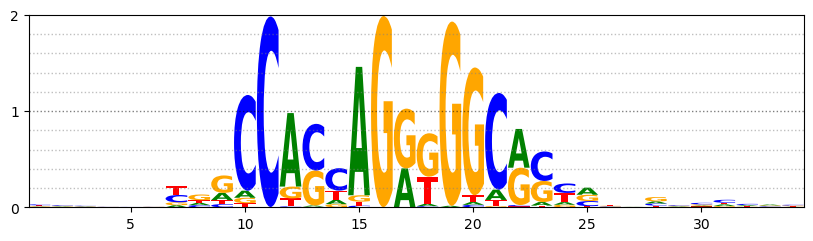

In [39]:
seqs,logopwm,logopssv = get_logos("primates/CTCF_primates.txt",κ,[15,48],[1,2,3,4,5]);
logopwm.fig

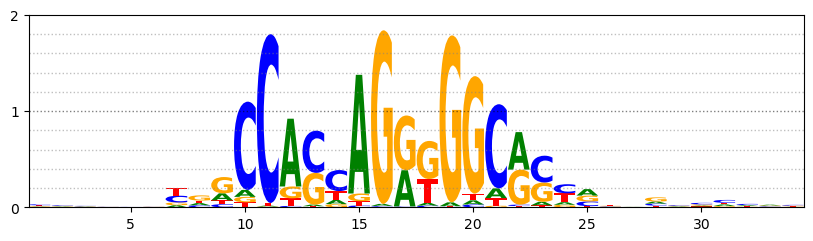

In [40]:
logopssv.fig

In [41]:
###### REST example

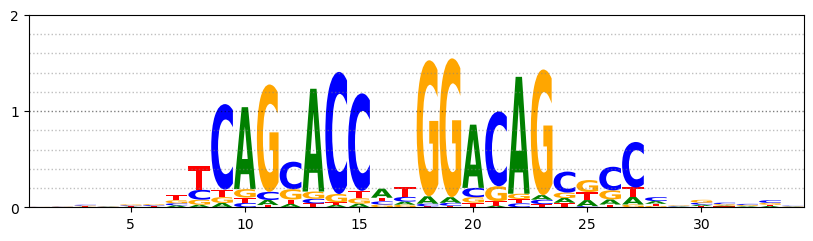

In [42]:
seqs,logopwm,logopssv = get_logos("primates/REST_primates.txt",κ,[15,48],[1,2,3,4,5]);
logopwm.fig

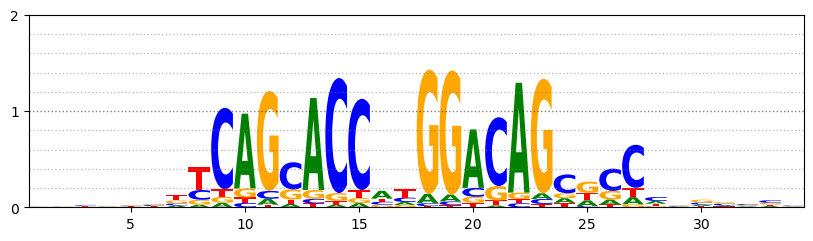

In [43]:
logopssv.fig

#### Can try with other examples in the "primates" directory

#### For "mammals" directory, use the appropriate tree and calculate its branchlengths first, as was done for the primate tree above